# Calculate Spatiotemporal Power Spectrum of Movies

After Video Frames have been temporally synced on a common timeframe with the eye trackers, we can extract video frames knowing they are temporally synced to the eye tracker. 

## Dependencies

In [1]:
import os, stat
import numpy as np
import matplotlib.pyplot as plt
import imp

import utils.run_analysis as ana

import stftoolkit as stf

## Parameters

*** NOTE: REALLY NEED TO CHECK ON THE VALUES FOR HORIZONTAL AND VERTICAL FOV ***

In [2]:
base_dir = '/data_repo/bravo'
data_dir = os.path.join(base_dir, 'raw_data')
output_dir = os.path.join(base_dir, 'analysis')

fps = 200

###DEFINITELY NEED TO CHECK ON THESE VALUES
horizontal_fov_deg = 80
vertical_fov_deg = 62

img_dims=(1544,2064)
save_batchsize = 200

chunk_secs = 5
chunk_pix = 128

#num_chunks = 5

cosine_window = True

vertical_ppd = img_dims[0]/vertical_fov_deg
horizontal_ppd = img_dims[1]/horizontal_fov_deg
ppd = np.mean((vertical_ppd, horizontal_ppd))
print(f'Vertical PPD: {vertical_ppd:.2f}, Horizontal PPD {horizontal_ppd:.2f}, taking average {ppd:.2f}')

Vertical PPD: 24.90, Horizontal PPD 25.80, taking average 25.35


## Specify Directories for Exmaple

In [3]:
example_subject = 'jf'
example_trial = 'laptop_2'
example_camera = 'cy'
trial_directory = os.path.join(data_dir, example_subject, example_trial, 'pre')
camera_dir = os.path.join(trial_directory,'scene_camera')

analysis_folder = os.path.join(output_dir, example_subject, example_trial,'')
common_timeline_file = os.path.join(analysis_folder,'common_timeline.npy')

#three trace conditions: true, none, temporal_match, spatial_match 
trace='none'

## Create Traces To Overlay

*** For now, only doing control conditions with random box in scene window. Later, the no trace condition should be MATCHED to a true fixation point START. ***

In [42]:
timeline = np.load(common_timeline_file)
timeline_stamps = timeline[:0]
timeline_ximea = timeline[:,1].astype(int)
timeline_pupil = timeline[:,2].astype(int)
timeline_task = timeline[:,3].astype(int)

#only use timelines during task
timeline_ximea = timeline_ximea[timeline_task==1]
timeline_pupil = timeline_pupil[timeline_task==1]

In [47]:
#generate a trace
chunk_fs = int(chunk_secs*fps)
if(trace == 'none'):
    trace_xy_corner = np.tile([np.random.randint(0,img_dims[0]-chunk_pix), np.random.randint(0,img_dims[1])-chunk_pix],(chunk_fs,1)) #top left corner
    trace_f_start = np.random.randint(0, len(timeline_pupil) - chunk_fs)
    trace_f = np.arange(trace_f_start, trace_f_start+chunk_fs)

    trace_ximea_fnum = timeline_ximea[trace_f]
    trace_pupil_fnum = timeline_pupil[trace_f]

## Extract Movie at Trace x, y, f position

In [49]:
#code to grab full size movie at trace time
#pull the movie at these frame numbers
#full_movie = np.zeros((len(trace_f),*img_dims,3))
#for i, f in enumerate(trace_f):
#    full_movie[i] = ana.ximea_get_frame(f, save_batchsize, example_camera, camera_dir, img_dims=(1544,2064), normalize=True)

movie_chunk = np.zeros((len(trace_f), chunk_pix, chunk_pix, 3))


for i, f in enumerate(trace_f):
    frame = ana.ximea_get_frame(timeline_ximea[i], save_batchsize, example_camera, camera_dir, img_dims=(1544,2064), normalize=True)
    movie_chunk[i] = frame[trace_xy_corner[i,0]:trace_xy_corner[i,0]+chunk_pix, 
                           trace_xy_corner[i,1]:trace_xy_corner[i,1]+chunk_pix]
    


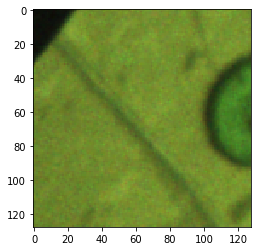

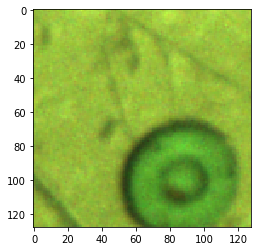

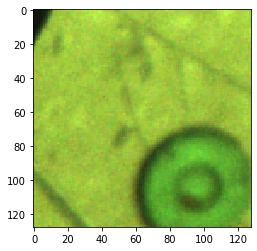

In [50]:
plt.imshow(movie_chunk[0])
plt.show()

plt.imshow(movie_chunk[np.shape(movie_chunk)[0]//2])
plt.show()

plt.imshow(movie_chunk[-1])
plt.show()


## Calculate the Spatiotemporal Fourier Transform of this Chunk

In [51]:
ps_3d, ps_2d, fqs_space, fqs_time = stf.st_ps(movie_chunk, cosine_window=False, rm_dc=True)

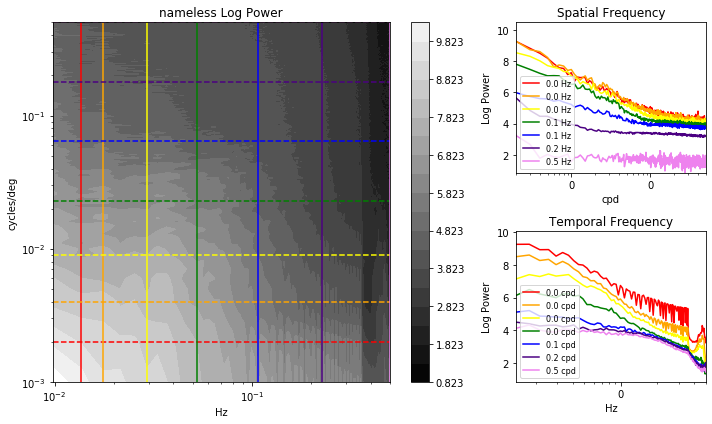

In [52]:
stf.da_plot_power(ps_2d, fqs_time, fqs_space)

## Take the Average of Many Chunks and create FT plot

In [11]:
#old code from fixational eye motion analysis.

print(f'Reading & Segmented Trace...', end='') # debugging
            drift_traces, sac_traces, control_traces, full_trace, trace_fps = rtr.readSegTraces(tracepath, crop=True, minlen_sec=nsecs_drift, resample=movfps)
            print(f'Done...', end='') # debugging

            # report what we'll do
            total_per_movie = len(drift_traces)*trace_resamples
            print(f'Sampling {len(drift_traces)} drift segs; {trace_resamples} resamples: {total_per_movie} total.')

            # loop through drift traces, sac and control have same indices
            for i in range(len(drift_traces)):

                drift_trace = drift_traces[i]
                sac_trace = control_traces[i]
                raw_trace = np.zeros_like(drift_trace) #control condition - no eye motion

                repeats = 0
                #  repeat the computation multiple times per trace
                while(repeats < trace_resamples):
                    repeats +=1
                    
                    #start with an empty movie to make sure the movie was calculated.
                    raw_overlayMov = []
                    c = []
                    trace_overlayMov = []
                    drift_overlayMov = []
                    
                    # just try again if our random numbers resultd in an incomplete movie:
                    # this is contingent on olm.OverlayMov returning 0 for an incomplete movie.
                    incomplete_counter = 0
                    #print(full_movie.shape, window_size)
                    while((len(trace_overlayMov)==0 or len(drift_overlayMov)==0) or len(raw_overlayMov)==0 ):
                        #print(len(trace_overlayMov),len(drift_overlayMov),len(raw_overlayMov))
                        #print(full_movie.shape, full_movie.shape[0]-raw_trace.shape[1]*movfps/trace_fps)
                        # get rand values for spatial and temporal offsets
                        # temporal offset should be between 0 and the total movie length less the chunk length.
                        t_starts = [np.random.randint(0, int(full_movie.shape[0]-raw_trace.shape[1]*movfps/trace_fps)),
                                  np.random.randint(0, int(full_movie.shape[0]-sac_trace.shape[1]*movfps/trace_fps)),
                                  np.random.randint(0, int(full_movie.shape[0]-drift_trace.shape[1]*movfps/trace_fps))]
                        
                        # spatial offset start should have a 1xwindow size border, and are calculated from (0,0).
                        x_offset = full_movie.shape[1]//2-window_size[0]//2
                        y_offset = full_movie.shape[2]//2-window_size[1]//2
                        # calc random positions in this range
                        x_starts = [np.random.randint(-x_offset, x_offset),
                                    np.random.randint(-x_offset, x_offset),
                                    np.random.randint(-x_offset, x_offset)]
                        y_starts = [np.random.randint(-y_offset, y_offset),
                                    np.random.randint(-y_offset, y_offset),
                                    np.random.randint(-y_offset, y_offset)]

                        raw_overlayMov = olm.overlayMov(full_movie, movfps, movie_ppd, raw_trace, trace_fps,
                                                        window_size, (x_starts[0], y_starts[0]), t_starts[0])
                        trace_overlayMov = olm.overlayMov(full_movie, movfps, movie_ppd, sac_trace, trace_fps,
                                                        window_size, (x_starts[1], y_starts[1]), t_starts[1])
                        drift_overlayMov = olm.overlayMov(full_movie, movfps, movie_ppd, drift_trace, trace_fps,
                                                        window_size, (x_starts[2], y_starts[2]), t_starts[2])
                        img_overlayMov = olm.overlayMov(img_movie, movfps, movie_ppd, drift_trace, trace_fps,
                                                        window_size, (x_starts[2], y_starts[2]), t_starts[2])
                        
                        incomplete_counter+=1
                        if(incomplete_counter % 1000==0):
                            print(f'Ovelay Failures: {incomplete_counter}: Window of trace overlay is probably wrong.')
                            
                    print('*',end='')

IndentationError: unexpected indent (<ipython-input-11-2b7dc2f7a786>, line 4)